# MOONPAY ASSESSMENT

## Installations

In [3]:
pip install requests beautifulsoup4

Note: you may need to restart the kernel to use updated packages.


## Imports

In [3]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup as bs4
import requests
from itertools import product
pd.set_option('display.max_rows', None)

## Part 1. Building a Scraper

Due to selenium and other website-emulating libraries not permitted, beautifulSoup will be used which is a non-emulating scraping tool. Along with beautifulSoup, requests library will be used to send GET requests with a specific url. The base `url` is `https://portfolio.metamask.io/buy/build-quote`. However, none of the required information or quotes are available. What we will do is build the url that is obtained from network tab. This url is the following API `https://on-ramp.api.cx.metamask.io/providers/all/quote?`. For each request, a payload will need to be created that will define the 5 parameters:  
- Country
- Fiat Currency
- Price point
- Crypto
- Payment Method

Additionally, the payload will also provide which crypto vendors are going to be scraped.

However, first an input dataframe needs to be created so the request can be hit over and over again for all possible combinations of inputs (country, price point, crypto, payment method). 

### 1.1. Static Inputs

These can be changed to dynamic provided it is a requirement. Note: Payment methods are written as a dictionary as they change based on the country. 

In [4]:
countries = ['us', 'gb', 'de']
cryptos = ['ethereum_mainnet', 'usdt_ether', 'usdt_bnb_chain']
payment_methods = {
    'gb': ['Faster payments', 'debit or credit', 'SEPA'],
    'de': ['debit or credit', 'SEPA', 'KHIPU'],
    'us': ['debit or credit', 'instant ACM']
}

In [5]:
def get_price_points(min_value=30, max_value=30000, bin_size=1000):
   
    # List to store the midpoints
    midpoints = []
    
    # Start from the minimum value
    current_bin_start = min_value
    
    while current_bin_start < max_value:
        # Define the end of the current bin
        current_bin_end = current_bin_start + bin_size
        
        # Ensure the end of the bin does not exceed the maximum value
        if current_bin_end > max_value:
            current_bin_end = max_value
        
        # Calculate the midpoint of the current bin
        midpoint = int((current_bin_start + current_bin_end) / 2)
        midpoints.append(midpoint)
        
        # Move to the next bin
        current_bin_start = current_bin_end
        
    return midpoints

values = get_price_points()

### 1.2. Creating an Input Dataframe

In [6]:
def generate_input_data(countries, cryptos, values, payment_methods): 
    country_crypto_value_combinations = list(product(countries, cryptos, values))
    data_rows = []
    for country, crypto, value in country_crypto_value_combinations: 
        for payment_method in payment_methods[country]: 
            data_rows.append([country, crypto,payment_method, value])

    df_input = pd.DataFrame(data_rows, columns = ['country', 'crypto','payment_method','value'])

    return df_input

df_input = generate_input_data(countries, cryptos, values, payment_methods)
df_input.head()

,country,crypto,payment_method,value
0,us,ethereum_mainnet,debit or credit,530
1,us,ethereum_mainnet,instant ACM,530
2,us,ethereum_mainnet,debit or credit,1530
3,us,ethereum_mainnet,instant ACM,1530
4,us,ethereum_mainnet,debit or credit,2530


### 1.3. Designing parameterized API endpoint

For each of the combinations, an custom API with relevant request headers a.k.a query parameters needs to be generated. The base url remains the same `https://on-ramp.api.cx.metamask.io/providers/all/quote?`. The following code creates a custom query parameter based on the input. The input is taken from `df_input` created above.

In [11]:
def build_query_with_params(region, payment, amount, crypto):
    
    fiat_curr_input : str
    region_input: str
    payment_input : str 
    fiat_value_input : str
    crypto_id_input :str
    
    crypto_dict = {
        "ethereum_mainnet":"1/0x0000000000000000000000000000000000000000", 
        "usdt_ether":"1/0xdac17f958d2ee523a2206206994597c13d831ec7",
        "usdt_bnb_chain":"56/0x55d398326f99059ff775485246999027b3197955",
    }

    crypto_id_input = crypto_dict.get(crypto, "Key Not Found")

    fiat_value_input = str(amount)

    if region == 'us': 
        region_input = 'us-tx'
    else: 
        region_input = region

    if payment == 'SEPA': 
        payment_input = 'sepa-bank-transfer'
    elif payment == 'debit or credit': 
        payment_input = 'debit-credit-card'
    elif payment == 'Faster payments': 
        payment_input = 'gbp-bank-transfer'
    elif payment == 'KHIPU': 
        payment_input = payment.lower()
    elif payment == 'instant ACM': 
        payment_input = 'instant-bank-transfer'


    if region == 'de': 
        fiat_curr_input = 'eur' 
    elif 'us' in region: 
        fiat_curr_input = 'usd'
    elif region == 'gb': 
        fiat_curr_input = 'gbp'

    query_params = {
        'regionId': f'/regions/{region_input}',
        'paymentMethodId': f'/payments/{payment_input}',
        'cryptoCurrencyId': f'/currencies/crypto/{crypto_id_input}',
        'fiatCurrencyId': f'/currencies/fiat/{fiat_curr_input}',
        'amount': f'{fiat_value_input}',
        'frequency': 'undefined',
        'sdk': '1.28.3',
        'context': 'browser',
        'keys': ''
    }

    return query_params
    

In [12]:
df_input['query_params'] = df_input.apply(
    lambda row: build_query_with_params(row['country'], row['payment_method'], row['value'], row['crypto']),
    axis=1
)

In [13]:
df_input.head()

,country,crypto,payment_method,value,query_params
0,us,ethereum_mainnet,debit or credit,530,"{'regionId': '/regions/us-tx', 'paymentMethodI..."
1,us,ethereum_mainnet,instant ACM,530,"{'regionId': '/regions/us-tx', 'paymentMethodI..."
2,us,ethereum_mainnet,debit or credit,1530,"{'regionId': '/regions/us-tx', 'paymentMethodI..."
3,us,ethereum_mainnet,instant ACM,1530,"{'regionId': '/regions/us-tx', 'paymentMethodI..."
4,us,ethereum_mainnet,debit or credit,2530,"{'regionId': '/regions/us-tx', 'paymentMethodI..."


The above dataframe (column `query_params`) will be used to feed the following function `hit_quote_api`. Query params is the custom payload that will accompany each request. To make it generic enough, the providers are not mentioned in the request. 

### 1.4. Obtaining Response from MetaMask API

The function below sends a `GET` request to metamask api to obtain the responses. The function also defines a dataframe `df_output` and creates rows for each provider for each request. For instance, one request might have 6 providers that are offering a quote. The output dataframe will therefore have 6 rows associated with that api. Ideally, each row in `df_input` would have a primary key signifying a unique combination of country, crypto, payment method and fiat value. This key would also be present in `df_output` to join the tables if desired. However, for the purposes of this task, this step is not done. 

`df_output` has the following columns: 
- *country* - country code used in the request (limited to: DE, US, UK)
- *crypto* - Crypto coin used for the request (limited to: ethereum_mainnet, usdt-thereum, usdt-bnb chain)
- *payment_method* - Payment method to transfer FIAT
- *fiat_value* - Fiat value requested
- *provider* - Crypto platform providing a quote
- *amount_in* - same as fiat value but obtained from the API response
- *amount_out* - amount of crypto coin that will be made available in the users' wallet. 
- *provider_fee* - providerFee in API response
- *network_fee* - networkFee in API response
- *extra_fee* - extraFee in API response
- *best_rate* - bestRate in API response. As per observation, when True this leads to the provider being shown first in UI. `true` if the provider has the bestRate, `false` if bestRate is not available in response. 
- *exchange_rate* - exchangeRate in API response. 



In [41]:
def hit_quote_api(country, crypto, payment_method, value, query_params): 
    url = 'https://on-ramp.api.cx.metamask.io/providers/all/quote'
    
    df_output = pd.DataFrame(columns=[
        'country', 'crypto', 'payment_method', 'fiat_value', 'provider',
        'amount_in', 'amount_out', 'provider_fee', 'network_fee', 'extra_fee',
        'best_rate', 'exchange_rate'
    ])

    try: 
        response = requests.get(url = url, params = query_params)
        if response.status_code == 200: 
            response_data = response.json()
            if 'success' in response_data: 
                for success_entry in response_data['success']: 
                    provider = success_entry['provider']
                    quote = success_entry['quote']
                    row = {
                        'country': country,
                        'crypto':crypto,
                        'payment_method': payment_method,
                        'fiat_value': value,
                        'provider': provider,
                        'amount_in': quote['amountIn'],
                        'amount_out': quote['amountOut'],
                        'exchange_rate':quote.get('exchangeRate', np.nan),
                        'network_fee':quote['networkFee'],
                        'provider_fee':quote['providerFee'],
                        'extra_fee':quote['extraFee'],
                        'best_rate':quote.get('bestRate',False)
                    }
                    df_output = df_output.append(row, ignore_index = True)
                        
        else:
            
            print(f'Country: {country}, crypto: {crypto}, payment_method: {payment_method}, value: {value}')
            print(response.status_code)

    except requests.RequestException as e: 
        print(f'Country: {country}, crypto: {crypto}, payment_method: {payment_method}, value: {value}')
        print(f'Failed to retrieve. {response.status_code}')

    return df_output

df_output = pd.concat(df_input.apply(
    
    lambda row: hit_quote_api(row['country'], row['crypto'], row['payment_method'],row['value'],row['query_params']),
    axis = 1
).to_list(), ignore_index = True)
        

Country: gb, crypto: usdt_bnb_chain, payment_method: SEPA, value: 530
500
Country: gb, crypto: usdt_bnb_chain, payment_method: SEPA, value: 1530
500
Country: gb, crypto: usdt_bnb_chain, payment_method: SEPA, value: 2530
500
Country: gb, crypto: usdt_bnb_chain, payment_method: SEPA, value: 3530
500
Country: gb, crypto: usdt_bnb_chain, payment_method: SEPA, value: 4530
500
Country: gb, crypto: usdt_bnb_chain, payment_method: SEPA, value: 5530
500
Country: gb, crypto: usdt_bnb_chain, payment_method: SEPA, value: 6530
500
Country: gb, crypto: usdt_bnb_chain, payment_method: SEPA, value: 7530
500
Country: gb, crypto: usdt_bnb_chain, payment_method: SEPA, value: 8530
500
Country: gb, crypto: usdt_bnb_chain, payment_method: SEPA, value: 9530
500
Country: gb, crypto: usdt_bnb_chain, payment_method: SEPA, value: 10530
500
Country: gb, crypto: usdt_bnb_chain, payment_method: SEPA, value: 11530
500
Country: gb, crypto: usdt_bnb_chain, payment_method: SEPA, value: 12530
500
Country: gb, crypto: us

As shown in the output above, there are cases with UK as the country where SEPA method is not available for `usdt bnb chain` transactions. It also seems debit or credit is not available beyond 24000. There were a couple of price points in DE and 2 price points in US which did not have data. For now, let's go with the data available. Ideally, further exploration should be made regarding price points. In total there are 39 entries that are deemed invalid.

In [47]:
df_output.head(10)

,country,crypto,payment_method,fiat_value,provider,amount_in,amount_out,provider_fee,network_fee,extra_fee,best_rate,exchange_rate,total_fees,est_ui_fiat_price,exc_sans_fees,implicit_fee,vendor
0,us,ethereum_mainnet,debit or credit,530,/providers/sardine-b,530,0.149672,0.00,0.34,0.00,True,3538.810375,0.34,529.66,529.66,0.0,sardine-b
1,us,ethereum_mainnet,debit or credit,530,/providers/sardine,530,0.149521,0.00,0.34,0.00,False,3542.372845,0.34,529.66,529.66,0.0,sardine
2,us,ethereum_mainnet,debit or credit,530,/providers/banxa,530,0.149363,0.00,0.38,0.00,False,3545.858077,0.38,529.62,529.62,0.0,banxa
3,us,ethereum_mainnet,debit or credit,530,/providers/stripe,530,0.148813,5.24,0.52,0.00,False,3522.803517,5.76,524.24,524.24,0.0,stripe
4,us,ethereum_mainnet,debit or credit,530,/providers/robinhood,530,0.148242,7.83,0.41,0.00,False,3519.650302,8.24,521.76,521.76,0.0,robinhood
5,us,ethereum_mainnet,debit or credit,530,/providers/moonpay,530,0.146800,12.79,0.61,5.11,False,NaN,18.51,511.49,511.49,0.0,moonpay
6,us,ethereum_mainnet,debit or credit,530,/providers/moonpay-b,530,0.146800,12.79,0.61,5.11,False,NaN,18.51,511.49,511.49,0.0,moonpay-b
7,us,ethereum_mainnet,debit or credit,530,/providers/unlimitmeld,530,0.145556,18.88,1.41,0.00,False,3501.820231,20.29,509.71,509.71,0.0,unlimitmeld
8,us,ethereum_mainnet,debit or credit,530,/providers/mercuryo,530,0.144724,19.82,0.35,0.00,False,3522.764635,20.17,509.83,509.83,0.0,mercuryo
9,us,ethereum_mainnet,debit or credit,530,/providers/ramp-network,530,0.144608,22.75,0.51,0.00,False,3504.229316,23.26,506.74,506.74,0.0,ramp-network


### 1.5. Feature Engineering

The task also mentions an implicit fee called spread. For calculating the spread a few columns are created. (amount_out * exchange_rate) 
- *est_ui_fiat_price*: Estimated price point seen in UI for the input price point. 
- *total_fees*: Sum of fees (provider_fee + network_fee + extra_fee)
- *exc_sans_fees*: fiat_value - total_fees
- *implicit_fees*: est_ui_fiat_price - exc_sans_fees

In [48]:
df_output['total_fees'] = df_output['provider_fee']+df_output['network_fee']+df_output['extra_fee']
df_output['est_ui_fiat_price'] = df_output.apply(
    lambda row: (
        row['exchange_rate'] * row['amount_out'] 
        if not pd.isna(row['exchange_rate']) and not pd.isna(row['amount_out'])
        else row['fiat_value'] - row['total_fees']
    ),
    axis=1
)
df_output['exc_sans_fees'] = df_output['fiat_value'] - df_output['total_fees']
df_output['implicit_fee'] = df_output['est_ui_fiat_price'] - df_output['exc_sans_fees'] 

df_output['vendor'] = df_output['provider'].str.split('/providers/').str[-1]

In [49]:
df_output.head(10)

,country,crypto,payment_method,fiat_value,provider,amount_in,amount_out,provider_fee,network_fee,extra_fee,best_rate,exchange_rate,total_fees,est_ui_fiat_price,exc_sans_fees,implicit_fee,vendor
0,us,ethereum_mainnet,debit or credit,530,/providers/sardine-b,530,0.149672,0.00,0.34,0.00,True,3538.810375,0.34,529.66,529.66,0.0,sardine-b
1,us,ethereum_mainnet,debit or credit,530,/providers/sardine,530,0.149521,0.00,0.34,0.00,False,3542.372845,0.34,529.66,529.66,0.0,sardine
2,us,ethereum_mainnet,debit or credit,530,/providers/banxa,530,0.149363,0.00,0.38,0.00,False,3545.858077,0.38,529.62,529.62,0.0,banxa
3,us,ethereum_mainnet,debit or credit,530,/providers/stripe,530,0.148813,5.24,0.52,0.00,False,3522.803517,5.76,524.24,524.24,0.0,stripe
4,us,ethereum_mainnet,debit or credit,530,/providers/robinhood,530,0.148242,7.83,0.41,0.00,False,3519.650302,8.24,521.76,521.76,0.0,robinhood
5,us,ethereum_mainnet,debit or credit,530,/providers/moonpay,530,0.146800,12.79,0.61,5.11,False,NaN,18.51,511.49,511.49,0.0,moonpay
6,us,ethereum_mainnet,debit or credit,530,/providers/moonpay-b,530,0.146800,12.79,0.61,5.11,False,NaN,18.51,511.49,511.49,0.0,moonpay-b
7,us,ethereum_mainnet,debit or credit,530,/providers/unlimitmeld,530,0.145556,18.88,1.41,0.00,False,3501.820231,20.29,509.71,509.71,0.0,unlimitmeld
8,us,ethereum_mainnet,debit or credit,530,/providers/mercuryo,530,0.144724,19.82,0.35,0.00,False,3522.764635,20.17,509.83,509.83,0.0,mercuryo
9,us,ethereum_mainnet,debit or credit,530,/providers/ramp-network,530,0.144608,22.75,0.51,0.00,False,3504.229316,23.26,506.74,506.74,0.0,ramp-network


Here we have all the base columns that is required. Additional columns can be engineered.

## Part 2. Save Data in BigQuery

Below, the numerical columns are converted to float 

In [50]:
df_output['fiat_value'] = pd.to_numeric(df_output['fiat_value'])
df_output['amount_in'] = pd.to_numeric(df_output['amount_in'])
df_output['amount_out'] = pd.to_numeric(df_output['amount_out'])
df_output['provider_fee'] = pd.to_numeric(df_output['provider_fee'])
df_output['network_fee'] = pd.to_numeric(df_output['network_fee'])
df_output['extra_fee'] = pd.to_numeric(df_output['extra_fee'])
df_output['total_fees'] = pd.to_numeric(df_output['total_fees'])
df_output['est_ui_fiat_price'] = pd.to_numeric(df_output['est_ui_fiat_price'])
df_output['exc_sans_fees'] = pd.to_numeric(df_output['exc_sans_fees'])
df_output['implicit_fee'] = pd.to_numeric(df_output['implicit_fee'])


In [52]:
df_output.to_csv('moonpay_assessment.csv')

This excel file is uploaded to Bigquery and can be accessed here `moonpay-project.assessment.scraping_output`.

## Part 3. Exploratory Data Analysis

### 3.1. Availability

In [59]:
vendor_country_counts = df_output.groupby(['country', 'vendor']).size().reset_index(name='count')

# Pivot the table to have countries as columns and vendors as rows
vendor_country_pivot = vendor_country_counts.pivot(index='vendor', columns='country', values='count').fillna(0)
vendor_country_pivot.reset_index(inplace=True)

condition = ~vendor_country_pivot['vendor'].str.endswith(('-m', '-p', '-b'))

# Apply the condition to filter the dataframe
filtered_vendor_country_pivot = vendor_country_pivot[condition]

# Reset the index for the filtered dataframe
filtered_vendor_country_pivot = filtered_vendor_country_pivot.reset_index(drop=True)
filtered_vendor_country_pivot

country,vendor,de,gb,us
0,banxa,135.0,0.0,45.0
1,blockchaindotcom,2.0,2.0,0.0
2,coinbase,14.0,12.0,64.0
3,mercuryo,120.0,100.0,60.0
4,moonpay,93.0,80.0,102.0
5,onramp-money,180.0,0.0,0.0
6,ramp-network,120.0,180.0,60.0
7,revolut,4.0,4.0,0.0
8,robinhood,0.0,0.0,10.0
9,sardine,56.0,46.0,120.0


There were a total of 720 API hits. 360 of them had `ramp-network`. `mercuryo` and its variant `mercuryo-p` are second. `Moonpay` is the third most widely available. Variants of different providers like `coinbase-m`, `moonpay-b`, `mercuryo-p`

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\CROMA\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


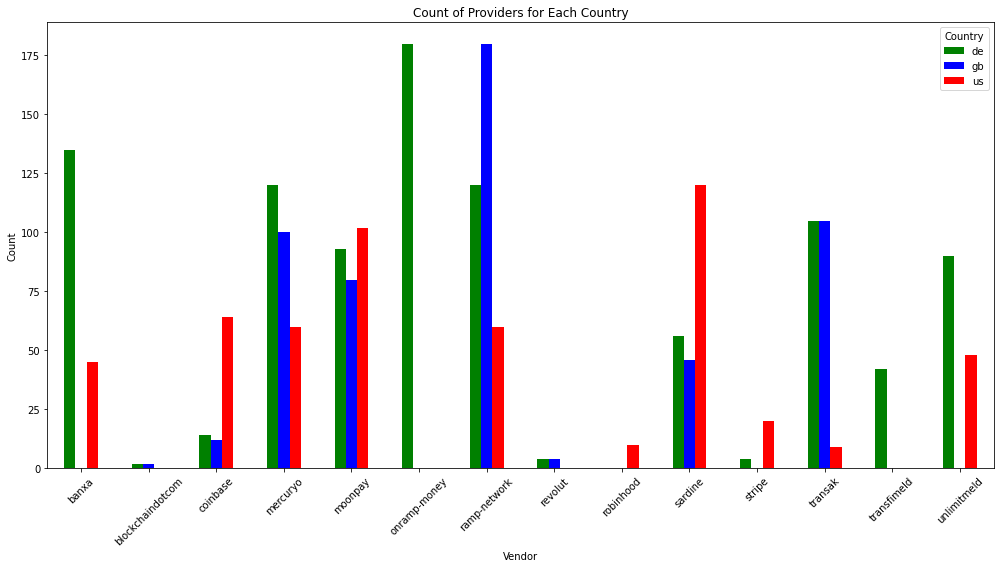

In [93]:

# Define colors for each country
colors = {'us': 'red', 'gb': 'blue', 'de': 'green'}

# Plot the data with specified colors
ax = filtered_vendor_country_pivot.plot(kind='bar', figsize=(14, 8), color=[colors[country] for country in filtered_vendor_country_pivot.columns])

# Set the title and labels
plt.title('Count of Providers for Each Country')
plt.xlabel('Vendor')
plt.ylabel('Count')
plt.legend(title='Country')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


Out of all the providers, moonpay seems to have consistent presence across all the three regions. The three comparable entities in terms of volume in all regions seem to be `mercuryo`, `ramp-network`, and to an extent `sardine`. Let's rank them by their total appearances in the API. 

In [75]:
vendor_counts = df_output['vendor'].value_counts()

# Convert to a DataFrame
vendor_counts_df = vendor_counts.reset_index()
vendor_counts_df.columns = ['vendor', 'count']
condition = ~vendor_counts_df['vendor'].str.endswith(('-m', '-p', '-b'))

filtered_vendor_pivot = vendor_counts_df[condition]
filtered_vendor_pivot['availability'] = 100*filtered_vendor_pivot['count']/(689)
filtered_vendor_pivot


C:\Users\CROMA\AppData\Local\Temp\ipykernel_24044\2387163078.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_vendor_pivot['availability'] = 100*filtered_vendor_pivot['count']/(689)


,vendor,count,availability
0,ramp-network,360,52.249637
2,mercuryo,280,40.638607
4,moonpay,275,39.912917
5,sardine,222,32.220610
8,transak,219,31.785196
9,banxa,180,26.124819
10,onramp-money,180,26.124819
11,unlimitmeld,138,20.029028
12,coinbase,90,13.062409
14,transfimeld,42,6.095791


`ramp-network` takes the top spot in terms of order volume. They have an availability of 52% of all valid APIs.  

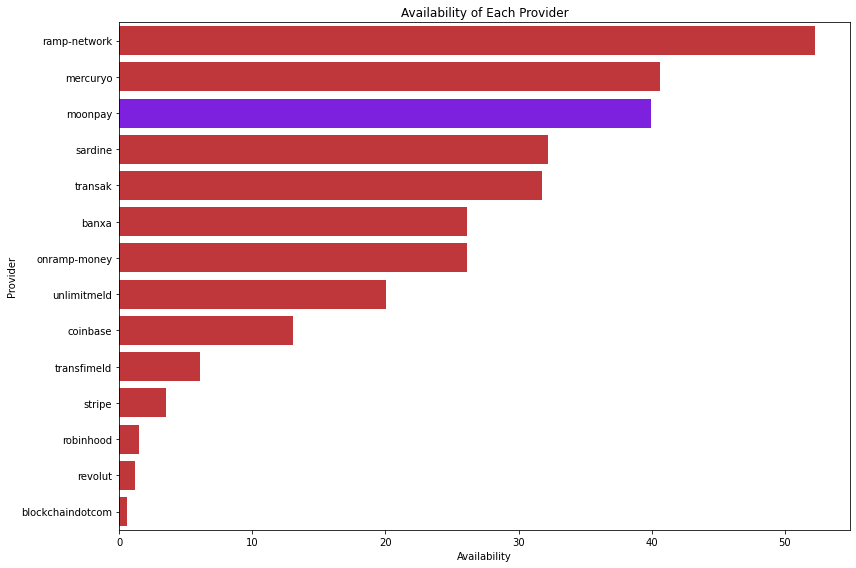

In [90]:
df_sorted = filtered_vendor_pivot.sort_values(by='availability', ascending=False)

# Create a custom color palette
colors = ['#D61F26' if vendor != 'moonpay' else '#7d02fd' for vendor in df_sorted['vendor']]

# Plotting with Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x='availability', y='vendor', data=df_sorted, palette=colors)
plt.xlabel('Availability')
plt.ylabel('Provider')
plt.title('Availability of Each Provider')
plt.tight_layout()
plt.show()

### 3.2. Fees

In [94]:
df_output['percent_prov_fee'] =  100*df_output['provider_fee']/df_output['amount_in']
df_output['percent_nw_fee'] = 100*df_output['network_fee']/df_output['amount_in']
df_output['percent_extra_fee'] = 100*df_output['extra_fee']/df_output['amount_in']
df_output['percent_total_fee'] = 100*df_output['total_fees']/df_output['amount_in']
df_output.head()

,country,crypto,payment_method,fiat_value,provider,amount_in,amount_out,provider_fee,network_fee,extra_fee,...,exchange_rate,total_fees,est_ui_fiat_price,exc_sans_fees,implicit_fee,vendor,percent_prov_fee,percent_nw_fee,percent_extra_fee,percent_total_fee
0,us,ethereum_mainnet,debit or credit,530,/providers/sardine-b,530,0.149672,0.00,0.34,0.0,...,3538.810375,0.34,529.66,529.66,0.0,sardine-b,0.000000,0.064151,0.0,0.064151
1,us,ethereum_mainnet,debit or credit,530,/providers/sardine,530,0.149521,0.00,0.34,0.0,...,3542.372845,0.34,529.66,529.66,0.0,sardine,0.000000,0.064151,0.0,0.064151
2,us,ethereum_mainnet,debit or credit,530,/providers/banxa,530,0.149363,0.00,0.38,0.0,...,3545.858077,0.38,529.62,529.62,0.0,banxa,0.000000,0.071698,0.0,0.071698
3,us,ethereum_mainnet,debit or credit,530,/providers/stripe,530,0.148813,5.24,0.52,0.0,...,3522.803517,5.76,524.24,524.24,0.0,stripe,0.988679,0.098113,0.0,1.086792
4,us,ethereum_mainnet,debit or credit,530,/providers/robinhood,530,0.148242,7.83,0.41,0.0,...,3519.650302,8.24,521.76,521.76,0.0,robinhood,1.477358,0.077358,0.0,1.554717


In [115]:
condition = ~df_output['vendor'].str.endswith(('-m', '-p', '-b'))
df_output_clean = df_output[condition]
average_percent_total_fee = df_output_clean.groupby(['country', 'payment_method', 'vendor','fiat_value','crypto'])['percent_total_fee','total_fees'].mean().reset_index()
average_percent_total_fee.head()

C:\Users\CROMA\AppData\Local\Temp\ipykernel_24044\671351701.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  average_percent_total_fee = df_output_clean.groupby(['country', 'payment_method', 'vendor','fiat_value','crypto'])['percent_total_fee','total_fees'].mean().reset_index()


,country,payment_method,vendor,fiat_value,crypto,percent_total_fee,total_fees
0,de,KHIPU,onramp-money,530,ethereum_mainnet,2.697600,14.29728
1,de,KHIPU,onramp-money,530,usdt_bnb_chain,1.954553,10.35913
2,de,KHIPU,onramp-money,530,usdt_ether,2.766613,14.66305
3,de,KHIPU,onramp-money,1530,ethereum_mainnet,2.175024,33.27786
4,de,KHIPU,onramp-money,1530,usdt_bnb_chain,1.917590,29.33913


In [116]:
fee_de = average_percent_total_fee[average_percent_total_fee['country']=='de']
fee_gb = average_percent_total_fee[average_percent_total_fee['country']=='gb']
fee_us = average_percent_total_fee[average_percent_total_fee['country']=='us']

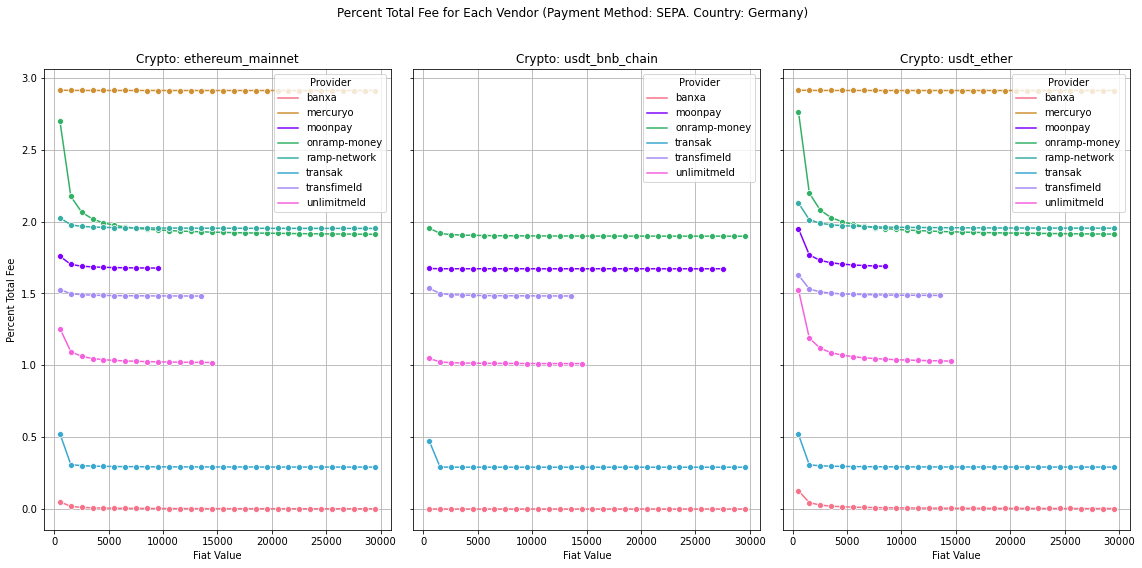

In [134]:
df_sepa = fee_de[fee_de['payment_method'] == 'SEPA']

cryptos = df_sepa['crypto'].unique()

# Get unique vendors
vendors = df_sepa['vendor'].unique()

# Define a color palette with a specific color for 'moonpay'
palette = sns.color_palette("husl", len(vendors))
vendor_colors = dict(zip(vendors, palette))
vendor_colors['moonpay'] = '#7d02fd'  # Set moonpay to a specific color

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=len(cryptos), figsize=(16, 8), sharey=True)

# Plot for each crypto
for ax, crypto in zip(axes, cryptos):
    df_crypto = df_sepa[df_sepa['crypto'] == crypto]
    sns.lineplot(data=df_crypto, x='fiat_value', y='percent_total_fee', hue='vendor', marker='o', ax=ax, palette=vendor_colors)
    ax.set_title(f'Crypto: {crypto}')
    ax.set_xlabel('Fiat Value')
    ax.set_ylabel('Percent Total Fee')
    ax.legend(title='Provider')
    ax.grid(True)

# Set the title and adjust layout
plt.suptitle('Percent Total Fee for Each Vendor (Payment Method: SEPA. Country: Germany)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

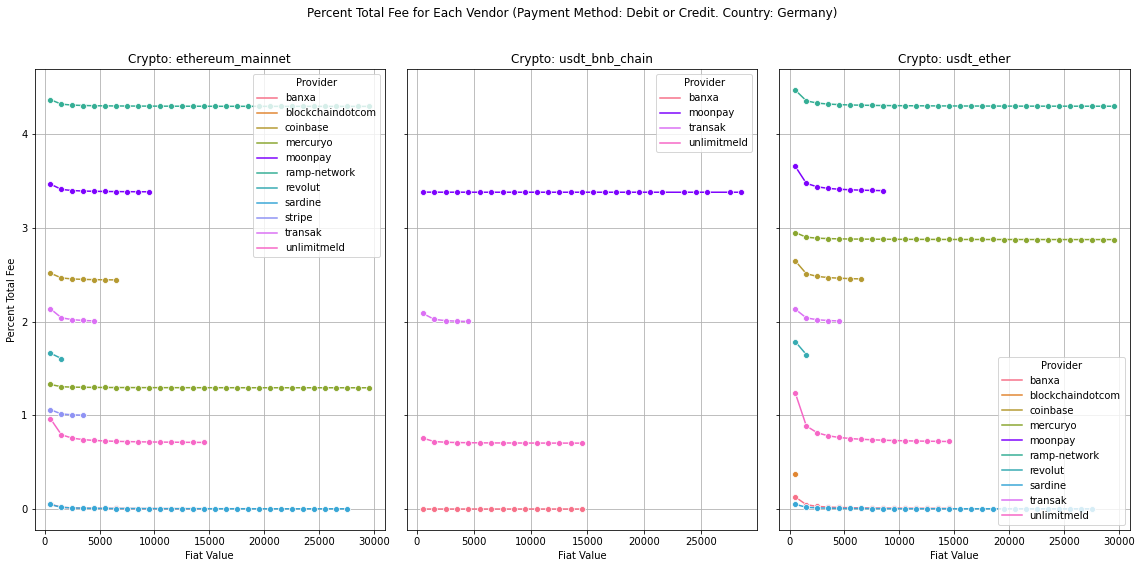

In [135]:
df_sepa = fee_de[fee_de['payment_method'] == 'debit or credit']


cryptos = df_sepa['crypto'].unique()

# Get unique vendors
vendors = df_sepa['vendor'].unique()


# Define a color palette with a specific color for 'moonpay'
palette = sns.color_palette("husl", len(vendors))
vendor_colors = dict(zip(vendors, palette))
vendor_colors['moonpay'] = '#7d02fd'  # Set moonpay to a specific color

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=len(cryptos), figsize=(16, 8), sharey=True)

# Plot for each crypto
for ax, crypto in zip(axes, cryptos):
    df_crypto = df_sepa[df_sepa['crypto'] == crypto]
    sns.lineplot(data=df_crypto, x='fiat_value', y='percent_total_fee', hue='vendor', marker='o', ax=ax, palette=vendor_colors)
    ax.set_title(f'Crypto: {crypto}')
    ax.set_xlabel('Fiat Value')
    ax.set_ylabel('Percent Total Fee')
    ax.legend(title='Provider')
    ax.grid(True)

# Set the title and adjust layout
plt.suptitle('Percent Total Fee for Each Vendor (Payment Method: Debit or Credit. Country: Germany)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

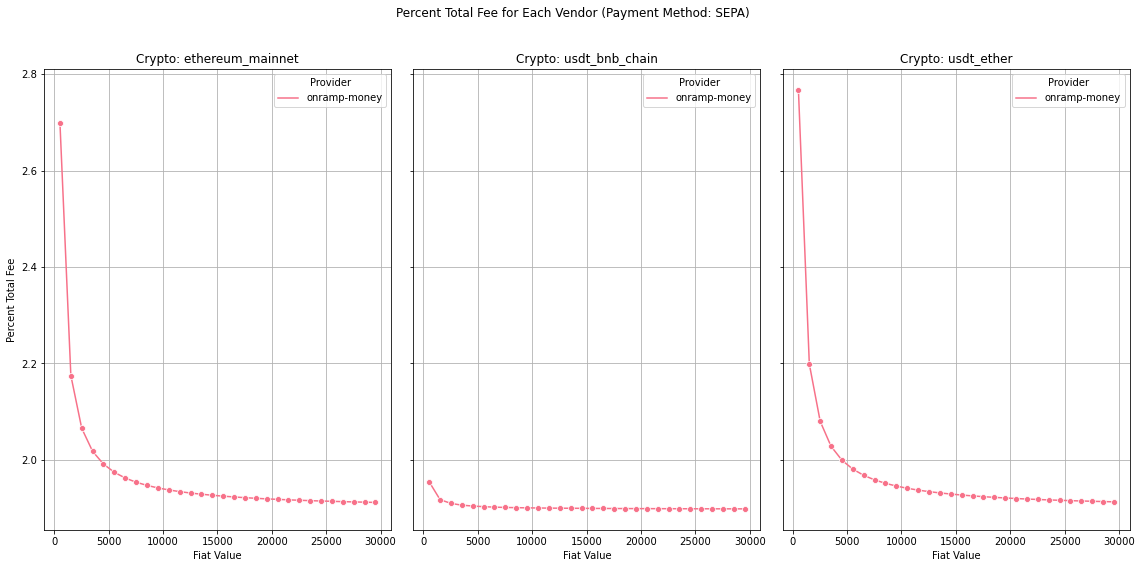

In [128]:
df_sepa = fee_de[fee_de['payment_method'] == 'KHIPU']

cryptos = df_sepa['crypto'].unique()

# Get unique vendors
vendors = df_sepa['vendor'].unique()


# Define a color palette with a specific color for 'moonpay'
palette = sns.color_palette("husl", len(vendors))
vendor_colors = dict(zip(vendors, palette))
vendor_colors['moonpay'] = '#7d02fd'  # Set moonpay to a specific color

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=len(cryptos), figsize=(16, 8), sharey=True)

# Plot for each crypto
for ax, crypto in zip(axes, cryptos):
    df_crypto = df_sepa[df_sepa['crypto'] == crypto]
    sns.lineplot(data=df_crypto, x='fiat_value', y='percent_total_fee', hue='vendor', marker='o', ax=ax, palette=vendor_colors)
    ax.set_title(f'Crypto: {crypto}')
    ax.set_xlabel('Fiat Value')
    ax.set_ylabel('Percent Total Fee')
    ax.legend(title='Provider')
    ax.grid(True)

# Set the title and adjust layout
plt.suptitle('Percent Total Fee for Each Vendor (Payment Method: SEPA)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### US

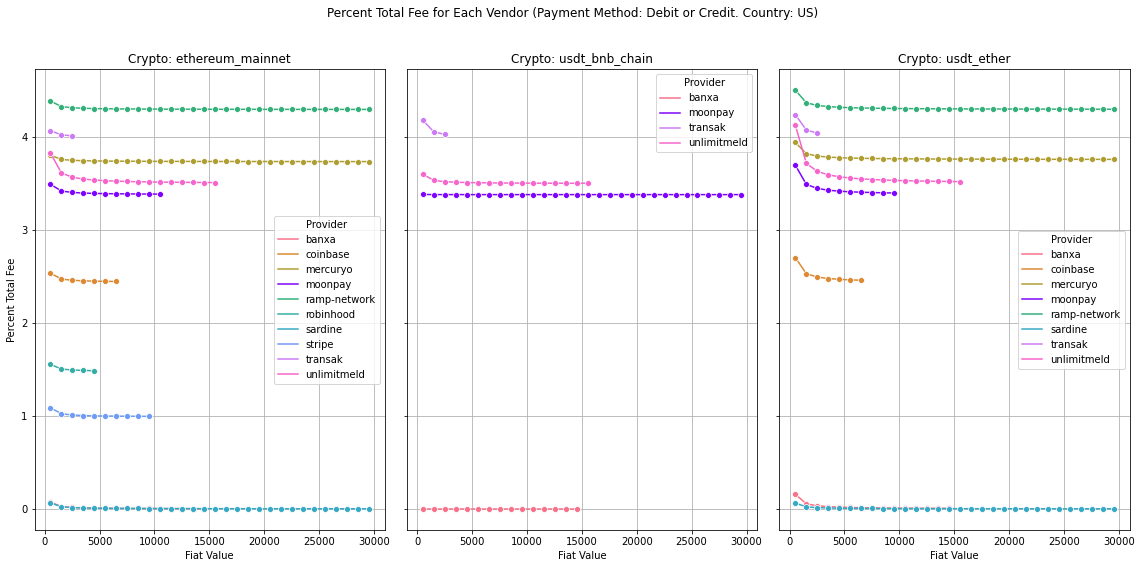

In [136]:
df_sepa = fee_us[fee_us['payment_method'] == 'debit or credit']

cryptos = df_sepa['crypto'].unique()

# Get unique vendors
vendors = df_sepa['vendor'].unique()


# Define a color palette with a specific color for 'moonpay'
palette = sns.color_palette("husl", len(vendors))
vendor_colors = dict(zip(vendors, palette))
vendor_colors['moonpay'] = '#7d02fd'  # Set moonpay to a specific color

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=len(cryptos), figsize=(16, 8), sharey=True)

# Plot for each crypto
for ax, crypto in zip(axes, cryptos):
    df_crypto = df_sepa[df_sepa['crypto'] == crypto]
    sns.lineplot(data=df_crypto, x='fiat_value', y='percent_total_fee', hue='vendor', marker='o', ax=ax, palette=vendor_colors)
    ax.set_title(f'Crypto: {crypto}')
    ax.set_xlabel('Fiat Value')
    ax.set_ylabel('Percent Total Fee')
    ax.legend(title='Provider')
    ax.grid(True)

# Set the title and adjust layout
plt.suptitle('Percent Total Fee for Each Vendor (Payment Method: Debit or Credit. Country: US)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

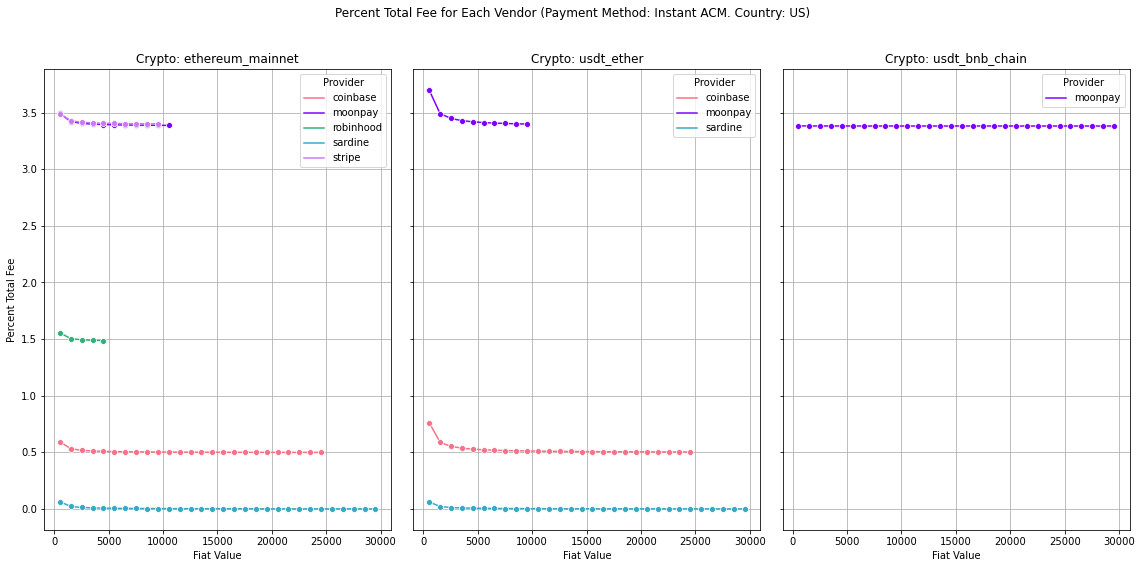

In [137]:
df_sepa = fee_us[fee_us['payment_method'] == 'instant ACM']

cryptos = df_sepa['crypto'].unique()

# Get unique vendors
vendors = df_sepa['vendor'].unique()


# Define a color palette with a specific color for 'moonpay'
palette = sns.color_palette("husl", len(vendors))
vendor_colors = dict(zip(vendors, palette))
vendor_colors['moonpay'] = '#7d02fd'  # Set moonpay to a specific color

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=len(cryptos), figsize=(16, 8), sharey=True)

# Plot for each crypto
for ax, crypto in zip(axes, cryptos):
    df_crypto = df_sepa[df_sepa['crypto'] == crypto]
    sns.lineplot(data=df_crypto, x='fiat_value', y='percent_total_fee', hue='vendor', marker='o', ax=ax, palette=vendor_colors)
    ax.set_title(f'Crypto: {crypto}')
    ax.set_xlabel('Fiat Value')
    ax.set_ylabel('Percent Total Fee')
    ax.legend(title='Provider')
    ax.grid(True)

# Set the title and adjust layout
plt.suptitle('Percent Total Fee for Each Vendor (Payment Method: Instant ACM. Country: US)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### GB

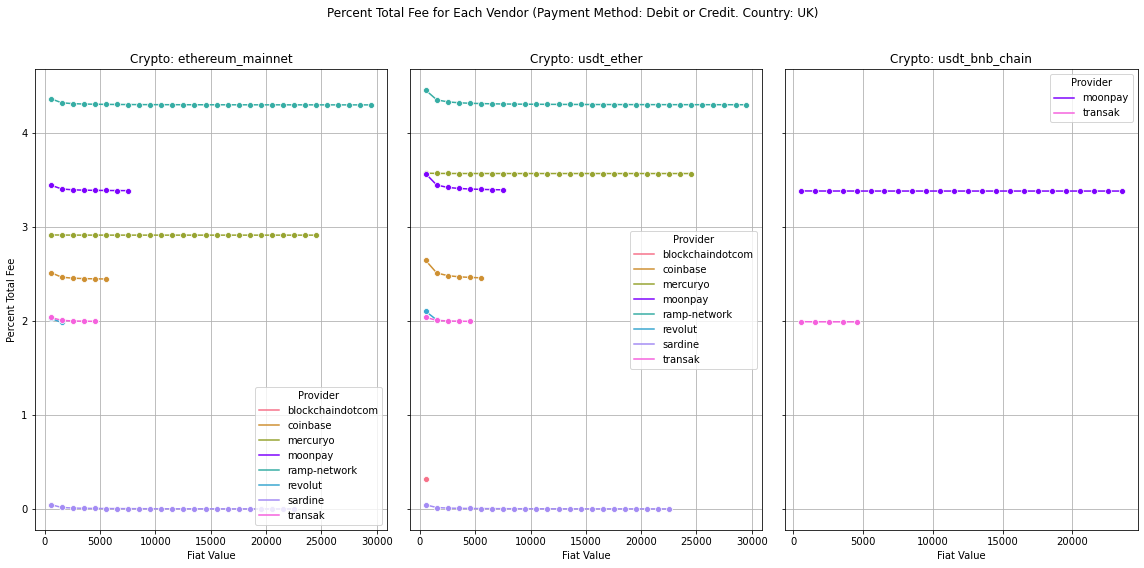

In [138]:
df_sepa = fee_gb[fee_gb['payment_method'] == 'debit or credit']

cryptos = df_sepa['crypto'].unique()

# Get unique vendors
vendors = df_sepa['vendor'].unique()


# Define a color palette with a specific color for 'moonpay'
palette = sns.color_palette("husl", len(vendors))
vendor_colors = dict(zip(vendors, palette))
vendor_colors['moonpay'] = '#7d02fd'  # Set moonpay to a specific color

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=len(cryptos), figsize=(16, 8), sharey=True)

# Plot for each crypto
for ax, crypto in zip(axes, cryptos):
    df_crypto = df_sepa[df_sepa['crypto'] == crypto]
    sns.lineplot(data=df_crypto, x='fiat_value', y='percent_total_fee', hue='vendor', marker='o', ax=ax, palette=vendor_colors)
    ax.set_title(f'Crypto: {crypto}')
    ax.set_xlabel('Fiat Value')
    ax.set_ylabel('Percent Total Fee')
    ax.legend(title='Provider')
    ax.grid(True)

# Set the title and adjust layout
plt.suptitle('Percent Total Fee for Each Vendor (Payment Method: Debit or Credit. Country: UK)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

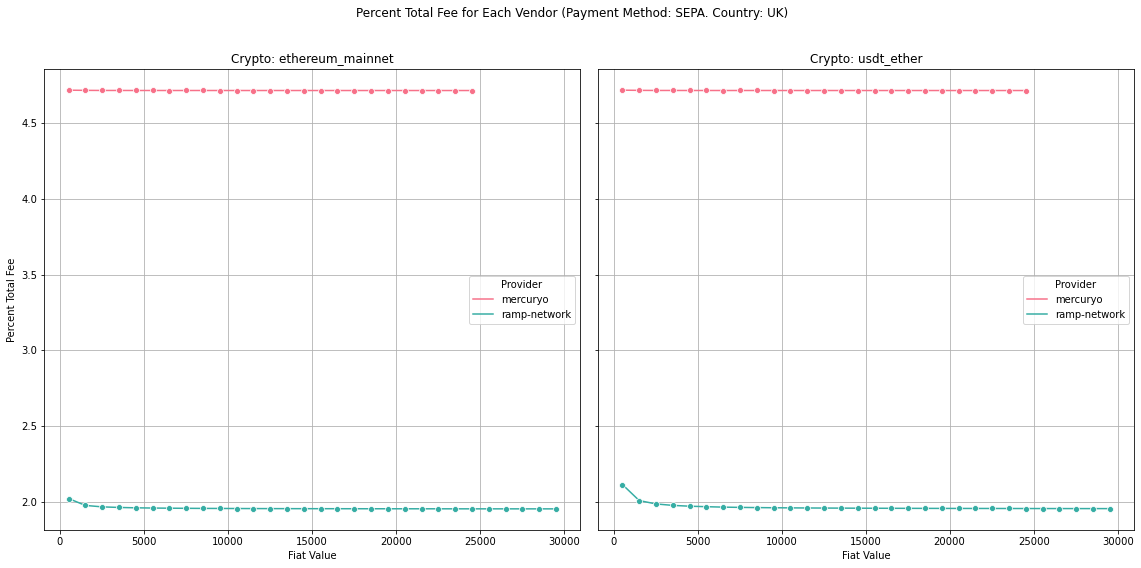

In [139]:
df_sepa = fee_gb[fee_gb['payment_method'] == 'SEPA']
cryptos = df_sepa['crypto'].unique()

# Get unique vendors
vendors = df_sepa['vendor'].unique()


# Define a color palette with a specific color for 'moonpay'
palette = sns.color_palette("husl", len(vendors))
vendor_colors = dict(zip(vendors, palette))
vendor_colors['moonpay'] = '#7d02fd'  # Set moonpay to a specific color

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=len(cryptos), figsize=(16, 8), sharey=True)

# Plot for each crypto
for ax, crypto in zip(axes, cryptos):
    df_crypto = df_sepa[df_sepa['crypto'] == crypto]
    sns.lineplot(data=df_crypto, x='fiat_value', y='percent_total_fee', hue='vendor', marker='o', ax=ax, palette=vendor_colors)
    ax.set_title(f'Crypto: {crypto}')
    ax.set_xlabel('Fiat Value')
    ax.set_ylabel('Percent Total Fee')
    ax.legend(title='Provider')
    ax.grid(True)

# Set the title and adjust layout
plt.suptitle('Percent Total Fee for Each Vendor (Payment Method: SEPA. Country: UK)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

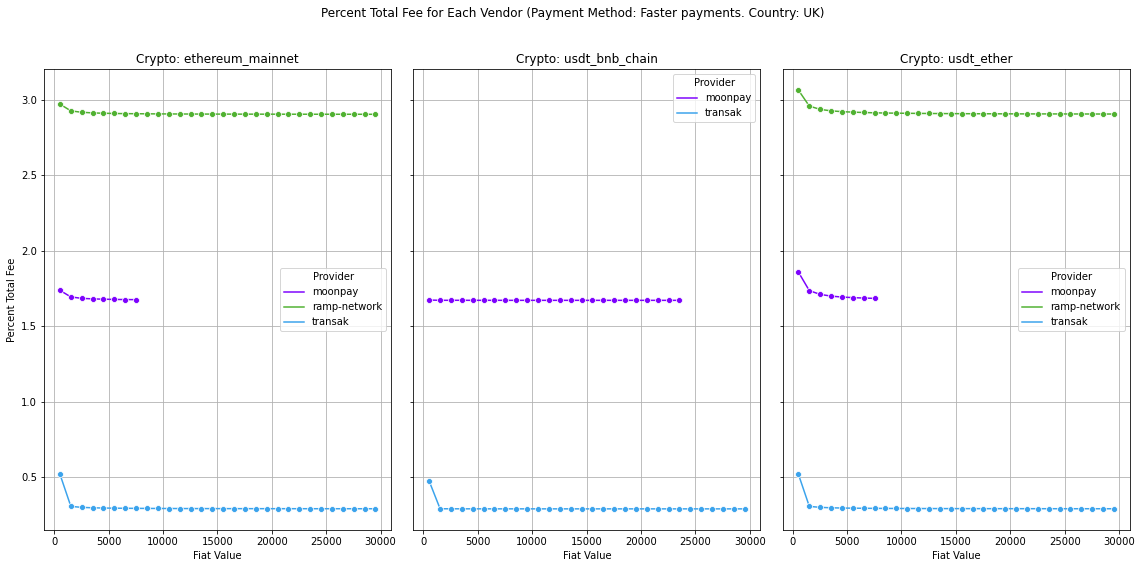

In [140]:
df_sepa = fee_gb[fee_gb['payment_method'] == 'Faster payments']

cryptos = df_sepa['crypto'].unique()

# Get unique vendors
vendors = df_sepa['vendor'].unique()


# Define a color palette with a specific color for 'moonpay'
palette = sns.color_palette("husl", len(vendors))
vendor_colors = dict(zip(vendors, palette))
vendor_colors['moonpay'] = '#7d02fd'  # Set moonpay to a specific color

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=len(cryptos), figsize=(16, 8), sharey=True)

# Plot for each crypto
for ax, crypto in zip(axes, cryptos):
    df_crypto = df_sepa[df_sepa['crypto'] == crypto]
    sns.lineplot(data=df_crypto, x='fiat_value', y='percent_total_fee', hue='vendor', marker='o', ax=ax, palette=vendor_colors)
    ax.set_title(f'Crypto: {crypto}')
    ax.set_xlabel('Fiat Value')
    ax.set_ylabel('Percent Total Fee')
    ax.legend(title='Provider')
    ax.grid(True)

# Set the title and adjust layout
plt.suptitle('Percent Total Fee for Each Vendor (Payment Method: Faster payments. Country: UK)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### 3.3. Ranking

Ranking is defined as the order in which providers are shown in the metamask UI. In the API there is not an explicit rank column provided. However, that rank can be inferred by the quoted value and the exchange rate. The best quote is ranked 1 and every subsequent provider within the country, crypto, fiat currency, and payment method combination is ranked by increasing quotation. Once any of the 4 parameters change the rank is restarted.

In [153]:
df_output_clean['rank'] = df_output_clean.groupby(['country', 'crypto', 'fiat_value', 'payment_method'])['amount_out'].rank(ascending=False, method='min').astype(int)

C:\Users\CROMA\AppData\Local\Temp\ipykernel_24044\2018136074.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_output_clean['rank'] = df_output_clean.groupby(['country', 'crypto', 'fiat_value', 'payment_method'])['amount_out'].rank(ascending=False, method='min').astype(int)


Below code creates a pivot table of the rank. On the x axis of this dataframe are ranks 1 through 11 and each row is a vendor. The cells describe the number of times they appeared in the corresponding rank for each vendor. 

In [178]:
rank_counts = df_output_clean.groupby(['vendor', 'rank']).size().unstack(fill_value=0)
rank_counts.reset_index(inplace=True)

In [179]:
rank_counts

rank,vendor,1,2,3,4,5,6,7,8,9,10,11
0,banxa,91,89,0,0,0,0,0,0,0,0,0
1,blockchaindotcom,2,0,0,1,0,1,0,0,0,0,0
2,coinbase,28,17,3,4,6,2,10,9,5,5,1
3,mercuryo,38,96,21,49,36,11,20,9,0,0,0
4,moonpay,98,56,35,37,25,18,3,2,1,0,0
5,onramp-money,90,0,15,16,30,6,13,10,0,0,0
6,ramp-network,70,96,93,12,28,41,9,8,2,1,0
7,revolut,2,2,0,1,1,1,1,0,0,0,0
8,robinhood,5,0,0,5,0,0,0,0,0,0,0
9,sardine,97,43,63,7,2,6,2,2,0,0,0


In [180]:
# Calculate the rank score for each vendor
def calculate_rank_score(row):
    rank_counts = row[1:]  # All rank columns (ignore the 'vendor' column)
    ranks = range(1, len(rank_counts) + 1)
    total_count = rank_counts.sum()
    weighted_sum = sum(r * count for r, count in zip(ranks, rank_counts))
    return weighted_sum / total_count if total_count > 0 else 0 

In [181]:
rank_counts['score'] = rank_counts.apply(calculate_rank_score, axis=1)

Join the vendor availability table to develop a 2-D matrix of availability and score for each of the vendor.

In [182]:
rank_counts.sort_values(by = 'score', ascending=True, inplace=True)
rank_counts

rank,vendor,1,2,3,4,5,6,7,8,9,10,11,score
0,banxa,91,89,0,0,0,0,0,0,0,0,0,1.494444
13,unlimitmeld,60,33,28,7,5,5,0,0,0,0,0,2.123188
9,sardine,97,43,63,7,2,6,2,2,0,0,0,2.144144
11,transak,100,48,37,20,2,3,5,1,3,0,0,2.214612
8,robinhood,5,0,0,5,0,0,0,0,0,0,0,2.500000
4,moonpay,98,56,35,37,25,18,3,2,1,0,0,2.698182
1,blockchaindotcom,2,0,0,1,0,1,0,0,0,0,0,3.000000
5,onramp-money,90,0,15,16,30,6,13,10,0,0,0,3.088889
6,ramp-network,70,96,93,12,28,41,9,8,2,1,0,3.138889
3,mercuryo,38,96,21,49,36,11,20,9,0,0,0,3.382143


In [184]:
df_merged = pd.merge(filtered_vendor_pivot, rank_counts, on='vendor', how='inner')
df_merged.sort_values(by ='score',ascending=True, inplace=True)
df_merged

,vendor,count,availability,1,2,3,4,5,6,7,8,9,10,11,score
5,banxa,180,26.124819,91,89,0,0,0,0,0,0,0,0,0,1.494444
7,unlimitmeld,138,20.029028,60,33,28,7,5,5,0,0,0,0,0,2.123188
3,sardine,222,32.220610,97,43,63,7,2,6,2,2,0,0,0,2.144144
4,transak,219,31.785196,100,48,37,20,2,3,5,1,3,0,0,2.214612
11,robinhood,10,1.451379,5,0,0,5,0,0,0,0,0,0,0,2.500000
2,moonpay,275,39.912917,98,56,35,37,25,18,3,2,1,0,0,2.698182
13,blockchaindotcom,4,0.580552,2,0,0,1,0,1,0,0,0,0,0,3.000000
6,onramp-money,180,26.124819,90,0,15,16,30,6,13,10,0,0,0,3.088889
0,ramp-network,360,52.249637,70,96,93,12,28,41,9,8,2,1,0,3.138889
1,mercuryo,280,40.638607,38,96,21,49,36,11,20,9,0,0,0,3.382143


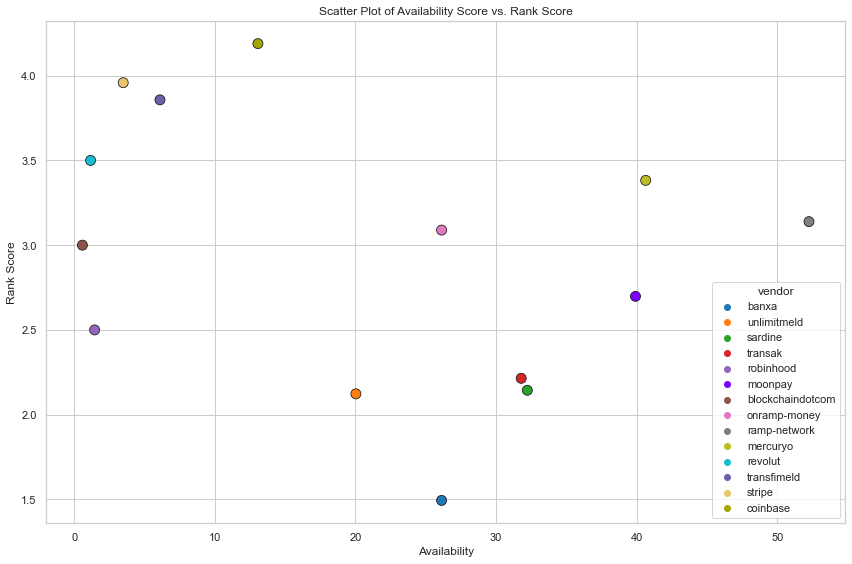

In [192]:
colors = {
    'moonpay': '#7d02fd',  # Purple color for moonpay
    'banxa': '#1f77b4',
    'unlimitmeld': '#ff7f0e',
    'sardine': '#2ca02c',
    'transak': '#d62728',
    'robinhood': '#9467bd',
    'blockchaindotcom': '#8c564b',
    'onramp-money': '#e377c2',
    'ramp-network': '#7f7f7f',
    'mercuryo': '#bcbd22',
    'revolut': '#17becf',
    'transfimeld': '#6d5eac',
    'stripe': '#e8c46d',
    'coinbase': '#a3a500',
    'default': '#d62728'  
}

plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_merged, x='availability', y='score', hue='vendor', palette=colors, s=100, edgecolor='k')

plt.title('Scatter Plot of Availability Score vs. Rank Score')
plt.xlabel('Availability')
plt.ylabel('Rank Score')


plt.grid(True)

plt.tight_layout()
plt.show()